# EEG Thinking and Counting 

10s - 10s



In [1]:
#Import necessary libraries

import pandas as pd
import numpy as np
from scipy import signal
import os
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pickle as pkl
import itertools 
import glob
from sklearn import svm 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

# %matplotlib inline 
%matplotlib qt


## Preprocessing

In [2]:
#Importing raw data files 

#.csv path
csvpath = "C:/Users/Wu Di/Documents/EEG-analysis/200108-Readings-csv/thinking-counting-switching.csv"

#Read .csv files
cols_to_use = list(range(4, 36))

#Raw dataframes - each channel is a column
raw_df = pd.read_csv(csvpath, header=None, usecols=cols_to_use)


In [3]:
#Bandpass (BP) filter helper functions

#Creates butterworth BP filter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5*fs  # Nyquist frequency, which is half of fs
    low = lowcut/nyq  # Digital butterworth filter cutoffs must be normalized to Nyquist frequency
    high = highcut/nyq
    b, a = signal.butter(order, [low, high], btype="bandpass")
    return b, a

def butter_lowpass(cutFreq,fs,order=5):
    nyq = 0.5*fs
    cutFreq = cutFreq/nyq
    b,a = signal.butter(order,cutFreq,btype="lowpass")
    return b,a 

def butter_highpass(cutFreq,fs,order=5):
    nyq = 0.5*fs
    cutFreq = cutFreq/nyq
    b,a = signal.butter(order,cutFreq,btype="highpass")
    return b,a 

#Applies butterworth BP filter
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
#     filtered_data = signal.lfilter(b, a, data)
    filtered_data = signal.filtfilt(b,a,data)
    return filtered_data

#Applies butterworth lowpass filter
def butter_lowpass_filter(data, cutFreq, fs, order=5):
    b, a = butter_lowpass(cutFreq,fs,order=5)
    filtered_data = signal.filtfilt(b,a,data)
    return filtered_data

#Applies butterworth lowpass filter
def butter_highpass_filter(data, cutFreq, fs, order=5):
    b, a = butter_highpass(cutFreq,fs,order=5)
    filtered_data = signal.filtfilt(b,a,data)
    return filtered_data

#Applies butterworth BP filter to Pandas dataframe 
def bp_filter_df(df, lowcut, highcut, fs, order):
    rows, cols = df.shape  # Get no. of rows and cols in df
    new_index = range(1, rows+1)
    new_cols = range(1, cols+1)
    # Create new df with same no. of rows and cols
    new_df = pd.DataFrame(index=new_index, columns=new_cols)
    # new_df = new_df.fillna(0) #Fill in 0 for all values
    for i in range(cols):  # Apply bp filter each column (channel) and saves in new_df
        filt_col = butter_bandpass_filter(
            df.iloc[:, i].values, lowcut, highcut, fs, order)
        new_df[i+1] = filt_col
    return new_df

#Applies butterworth lowpass filter to Pandas dataframe 
def lp_filter_df(df, cutFreq, fs, order):
    rows, cols = df.shape  # Get no. of rows and cols in df
    new_index = range(1, rows+1)
    new_cols = range(1, cols+1)
    # Create new df with same no. of rows and cols
    new_df = pd.DataFrame(index=new_index, columns=new_cols)
    # new_df = new_df.fillna(0) #Fill in 0 for all values
    for i in range(cols):  # Apply bp filter each column (channel) and saves in new_df
        filt_col = butter_lowpass_filter(
            df.iloc[:, i].values, cutFreq, fs, order)
        new_df[i+1] = filt_col
    return new_df

#Applies butterworth highpass filter to Pandas dataframe 
def hp_filter_df(df, cutFreq, fs, order):
    rows, cols = df.shape  # Get no. of rows and cols in df
    new_index = range(1, rows+1)
    new_cols = range(1, cols+1)
    # Create new df with same no. of rows and cols
    new_df = pd.DataFrame(index=new_index, columns=new_cols)
    # new_df = new_df.fillna(0) #Fill in 0 for all values
    for i in range(cols):  # Apply bp filter each column (channel) and saves in new_df
        filt_col = butter_highpass_filter(
            df.iloc[:, i].values, cutFreq, fs, order)
        new_df[i+1] = filt_col
    return new_df

In [4]:
#Apply BP filtering to raw dataframes
def filt_freq_bands(df,fs):
    delta = lp_filter_df(df, 4.5, fs, 10) 
    theta = bp_filter_df(df, 3.5, 8.5, fs, 6)
    alpha = bp_filter_df(df, 7.5, 12.5, fs, 8)
    beta = bp_filter_df(df, 11.5, 30.5, fs, 16)
    gamma = hp_filter_df(df, 29.5, fs, 50)
    return [delta, theta, alpha, beta, gamma]

fs = 128
# order = 6

all_bands_list = filt_freq_bands(raw_df,fs)

#Split into thinking and counting data frames
think_index_list = []
count_index_list = []

for i in range(6):
    if i%2==0:
        think_index_list+=(list(range(1280*i,1280*(i+1))))
    else:
        count_index_list+=(list(range(1280*i,1280*(i+1))))

think_bands_list = []
count_bands_list = []

for i in range(len(all_bands_list)):
    df = all_bands_list[i].iloc[0:1280*6]
    df_list = np.vsplit(df,6)
    think_df = pd.DataFrame(np.vstack((df_list[0],df_list[2],df_list[4])))
    think_bands_list.append(think_df)
    count_df = pd.DataFrame(np.vstack((df_list[1],df_list[3],df_list[5])))
    count_bands_list.append(count_df)

print(think_bands_list[0].shape)
print(count_bands_list[0].shape)

(3840, 32)
(3840, 32)


In [5]:
#Split filtered dataframes into samples
fs = 128 #sampling freq
sample_t = 0.1 #sample time length in seconds

#Splits a single dataframe into list of equally sized arrays
#Each element in list is nx32 array, where n= sample length 
def split_df(df,fs,sample_t,check=False):
    rows,_ = df.shape #get no. of rows
    sample_len = int(sample_t*fs) #find no. of recorded samples required for each sample time length
    Ns = int(rows/sample_len) #find total no. of samples
    df_cut = df.loc[:Ns*sample_len] #truncate dataframe to exact multiple of sample length
    df_split_list = np.vsplit(df_cut,Ns) #split dataframe row-wise, returns a list
    
    if check:
        print("Total no. of recorded samples: "+str(rows))
        print("Sample length: "+str(sample_len))
        print("Total no. of samples: "+str(Ns))
        print("Length of df_split_list: "+str(len(df_split_list)))
        
        if all(isinstance(x.shape,tuple) for x in df_split_list):
            print("Shape of each element in df_split_list: "+str(df_split_list[0].shape))
        else:
            print("Shapes are wrong.")
            for x in df_split_list:
                print(x.shape)
    return df_split_list,Ns

#Apply split_df() function to list of dataframes, reshape dataframe such that each element is an array 
#for the appropriate sample time length 
def split_bands_list(bands_list,fs,sample_t,check=False,checkSD=False):
    df_list_rFE = [0]*len(bands_list) #dataframes list ready for feature extraction 
    for df_no in range(len(bands_list)):
        df_split_list,Ns = split_df(bands_list[df_no],fs,sample_t,check=checkSD)
        list_of_series = [0]*Ns
        for i in range(len(df_split_list)):
            #New dataframe will have shape Nsx32, each element is a 1xsample_len array 
            new_row = [0]*32 
            #Each df_split_list[i] is a dataframe
            for j in range(len(df_split_list[i].columns)):
                new_row[j] = df_split_list[i].iloc[:,j].values 
            list_of_series[i] = new_row
        df_list_rFE[df_no] = pd.DataFrame(list_of_series)
    if check:
        print("Length of bands_list: "+str(len(bands_list)))
        print("Length of df_list_rFE: "+str(len(df_list_rFE)))
        if (all(isinstance(x.shape,tuple) for x in df_list_rFE)) and (Ns==len(df_list_rFE[0].index)):
            print("Shape of each dataframe in df_list_rFE: "+str(df_list_rFE[0].shape))
    return df_list_rFE
            
T_bands_split_list = split_bands_list(think_bands_list,fs,sample_t,check=True,checkSD=True)
C_bands_split_list = split_bands_list(count_bands_list,fs,sample_t,check=True,checkSD=True)


Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Shape of each element in df_split_list: (12, 32)
Length of bands_list: 5
Length of df_list_rFE: 5
Shape of each dataframe in df_list_rFE: (320, 32)
Total no. of recorded samples: 3840
Sample length: 12
Total no. of samples: 320
Length of df_split_list: 320
Sh

## Feature Extraction

In [6]:
#Apply Welch's method for each item in the dataframes

def welch_bands_split_list(bands_list,fs,win,check=False):
    #fs -sampling freq, win - number of recorded samples in window
    #Using this method, freq resolution = 1/t = fs/N (N=no.of points in windows)
    PSD_df_list = [0]*len(bands_list)
    for df_no in range(len(bands_list)):
        #Every item in the dataframe is mapped to the PSD estimates
        PSD_df_list[df_no] = bands_list[df_no].applymap(lambda x: signal.welch(x,fs,nperseg=win)[1])
    #Frequency axis for plotting, samee for all
    freqs,_ = signal.welch(bands_list[0].iloc[0,0],fs,nperseg=win)
    
    if check:
        if all(isinstance(x.shape,tuple) for x in PSD_df_list):
            print(PSD_df_list[0].shape)
#         if len(PSD_df_list[0].iloc[0,0]) == len(PSD_df_list[1].iloc[0,0]) == len(PSD_df_list[2].iloc[0,0]) == len(PSD_df_list[3].iloc[0,0]):
#             len(PSD_df_list[0].iloc[0,0]
    
    return freqs, PSD_df_list

fs = 128 
win = 6 #Half of sample length (12)

#Get PSD estimates, freqs is the same for all
freqs, T_PSD_df_list = welch_bands_split_list(T_bands_split_list,fs,win,check=True)
_, C_PSD_df_list = welch_bands_split_list(C_bands_split_list,fs,win,check=True)


(320, 32)
(320, 32)


In [7]:
#Create features from PSD 

def get_AUC_PSD_df_list(PSD_df_list):
    AUC_PSD_df_list = [0]*len(PSD_df_list)
    for df_no in range(len(PSD_df_list)):
        AUC_PSD_df_list[df_no] = PSD_df_list[df_no].applymap(lambda x: np.trapz(x))
    return AUC_PSD_df_list

T_AUC_PSD_df_list = get_AUC_PSD_df_list(T_PSD_df_list)
C_AUC_PSD_df_list = get_AUC_PSD_df_list(C_PSD_df_list)

In [8]:
#Expand all lists in cells to their own variables

def expand_PSD_df_list(PSD_df_list):
    e_PSD_df_list = [0]*len(PSD_df_list)
    for df_no in range(len(PSD_df_list)):
        #e_PSD_df_cols_list will be used to create new dataframe
        no_PSD = len(PSD_df_list[0].iloc[0,0])
        e_PSD_df_cols_list = [0]*32
        
        for channel in range(len(PSD_df_list[df_no].columns)):
            #Expand each column into its own dataframe
            new_col = PSD_df_list[df_no][channel].apply(pd.Series)
            #Rename every variable in the new column
            new_col = new_col.rename(columns = lambda x: "Ch"+str(channel+1)+'_'+str(np.linspace(0,64,no_PSD)[x]))
            #Add new_col to cols_list
            e_PSD_df_cols_list[channel] = new_col
        
        #Create new dataframe
        e_PSD_df = pd.concat(e_PSD_df_cols_list, axis=1)
        
        #Add to list
        e_PSD_df_list[df_no] = e_PSD_df
    return e_PSD_df_list 

T_e_PSD_df_list = expand_PSD_df_list(T_PSD_df_list)
C_e_PSD_df_list = expand_PSD_df_list(C_PSD_df_list)

print(T_e_PSD_df_list[0].shape)
print(C_e_PSD_df_list[0].shape)

(320, 128)
(320, 128)


In [9]:
#Create datasets with all possible combinations of frequency bands

indices = [0,1,2,3,4] #indices representing delta, theta, alpha, beta, gamma bands in order

def all_combinations(any_list):
    return itertools.chain.from_iterable(
        itertools.combinations(any_list, i + 1)
        for i in range(len(any_list)))

combos = list(all_combinations(indices)) #2^(len(indices))-1 combinations

print(combos)
print(type(combos[0]))
print(len(combos))

[(0,), (1,), (2,), (3,), (4,), (0, 1), (0, 2), (0, 3), (0, 4), (1, 2), (1, 3), (1, 4), (2, 3), (2, 4), (3, 4), (0, 1, 2), (0, 1, 3), (0, 1, 4), (0, 2, 3), (0, 2, 4), (0, 3, 4), (1, 2, 3), (1, 2, 4), (1, 3, 4), (2, 3, 4), (0, 1, 2, 3), (0, 1, 2, 4), (0, 1, 3, 4), (0, 2, 3, 4), (1, 2, 3, 4), (0, 1, 2, 3, 4)]
<class 'tuple'>
31


In [10]:
#Concatenate to form all possible dataframes (PSD and AUC features)

#Only PSD features
#Only AUC features 
#Both PSD and AUC features 

def get_1F_combos_df_list(e_PSD_df_list,combos): 
    #single feature
    combos_df_list = [0]*len(combos)
    for i in range(len(combos)):
        concat_list = [e_PSD_df_list[x] for x in combos[i]]
        combos_df_list[i] = pd.concat(concat_list,axis=1)
    return combos_df_list

def get_2F_combos_df_list(PSD_df_list,AUC_df_list,combos):
    #Two features
    combos_df_list = [0]*len(combos)
    for i in range(len(combos)):
        psd_list = [PSD_df_list[x] for x in combos[i]]
        auc_list = [AUC_df_list[x] for x in combos[i]]
        concat_list = psd_list + auc_list 
        combos_df_list[i] = pd.concat(concat_list,axis=1)
    return combos_df_list

#List of dataframes with only PSD features
T_PSD_combos_df_list = get_1F_combos_df_list(T_e_PSD_df_list,combos)
C_PSD_combos_df_list = get_1F_combos_df_list(C_e_PSD_df_list,combos)

#List of dataframes with only AUC features
T_AUC_combos_df_list = get_1F_combos_df_list(T_AUC_PSD_df_list,combos)
C_AUC_combos_df_list = get_1F_combos_df_list(C_AUC_PSD_df_list,combos)

#List of dataframes with both features
T_2F_combos_df_list = get_2F_combos_df_list(T_e_PSD_df_list,T_AUC_PSD_df_list,combos)
C_2F_combos_df_list = get_2F_combos_df_list(C_e_PSD_df_list,C_AUC_PSD_df_list,combos)

print(len(T_2F_combos_df_list))
print(C_2F_combos_df_list[30].shape)
print(len(C_2F_combos_df_list))
print(C_2F_combos_df_list[30].shape)


31
(320, 800)
31
(320, 800)


In [11]:
#Append action type columns to all dataframes 

def add_music_col(df_list,music_type):
    new_list = [0]*len(df_list)
    for i in range(len(df_list)):
        new_df = df_list[i][:]
        new_df['Action'] = pd.Series(music_type,index=df_list[i].index) #add new column
        new_list[i] = new_df
    return new_list

#Lists
#List of dataframes with only PSD features
T_PSD_combosA_df_list = add_music_col(T_PSD_combos_df_list,'T')
C_PSD_combosA_df_list = add_music_col(C_PSD_combos_df_list,'C')

# #List of dataframes with only AUC features
T_AUC_combosA_df_list = add_music_col(T_AUC_combos_df_list,'T')
C_AUC_combosA_df_list = add_music_col(C_AUC_combos_df_list,'C')

# #List of dataframes with both features
T_2F_combosA_df_list = add_music_col(T_2F_combos_df_list,'T')
C_2F_combosA_df_list = add_music_col(C_2F_combos_df_list,'C')

print(len(T_PSD_combosA_df_list))
print(len(C_PSD_combosA_df_list))

31
31


In [81]:
#Combine different class types to form full datasets

#Create list of strings representing combinations of frequency bands to append to saved files
def get_combo_strings(combos):
    combo_strings = []
    for combo in combos:
        strings = [str(x) for x in combo]
        string = ''
        for i in range(len(strings)):
            string += strings[i]
        combo_strings.append(string)
    return combo_strings
combo_strings = get_combo_strings(combos)

def concatSave_df_list(concat_list,T_df_list,C_df_list,combo_strings,filename,savedir,save=False):
    if len(C_df_list) == len(T_df_list) :
        for i in range(len(C_df_list)):
            new_df = pd.concat([T_df_list[i],C_df_list[i]],axis=0)
            concat_list.append(new_df)
            # print(len(concat_list))
            if save:
                savepath = savedir+filename+'_'+ combo_strings[i]+'.pkl'
                #Save to external HDD as pkl files 
                new_df.to_pickle(savepath)
    else:
        print("Lists are of unequal lengths.")


PSDsavedir = 'F:\EEG-data\\think-count\\featureExtraction/PSD_only/'
AUCsavedir = 'F:\EEG-data\\think-count\\featureExtraction/AUC_only/'
AUC_PSDsavedir = 'F:\EEG-data\\think-count\\featureExtraction/AUC_PSD/'

PSD_filename = 'PSD_df'
AUC_filename = 'AUC_df'
AUC_PSDfilename = 'AUC_PSD_df'

PSD_combosA_df_list = []
AUC_combosA_df_list = []
AUC_PSD_combosA_df_list =[]
#"combosA" means "Action" column has been added
#List of dataframes with only PSD features
concatSave_df_list(PSD_combosA_df_list,T_PSD_combosA_df_list,C_PSD_combosA_df_list, combo_strings,PSD_filename,PSDsavedir)


#List of dataframes with only AUC features
concatSave_df_list(AUC_combosA_df_list,T_AUC_combosA_df_list,C_AUC_combosA_df_list, combo_strings,AUC_filename,AUCsavedir)

#List of dataframes with both features
concatSave_df_list(AUC_PSD_combosA_df_list,T_2F_combosA_df_list,C_2F_combosA_df_list, combo_strings,AUC_PSDfilename,AUC_PSDsavedir)


print(len(PSD_combosA_df_list))
print(len(AUC_combosA_df_list))
print(len(AUC_PSD_combosA_df_list))

31
31
31


In [85]:
#Function for feature scaling

PSDsavedir = 'F:\EEG-data\\think-count\\featureExtraction/PSD_only/'
AUCsavedir = 'F:\EEG-data\\think-count\\featureExtraction/AUC_only/'
AUC_PSDsavedir = 'F:\EEG-data\\think-count\\featureExtraction/AUC_PSD/'

PSD_filename = 'PSD_df'
AUC_filename = 'AUC_df'
AUC_PSDfilename = 'AUC_PSD_df'

def featureScaling_df(combosA_df_list,combo_strings,filebase,savedir):
    sc = StandardScaler()
    for i in range(len(combosA_df_list)):
        filename = filebase+'_'+ combo_strings[i]+'.pkl'
        df = combosA_df_list[i]
        cols = df.columns
        data = df.iloc[:,0:-1]
        class_type = df.iloc[:,-1].values
        class_type = np.reshape(class_type,(len(class_type),1))
        scaled_data = sc.fit_transform(data)
        new_df = pd.DataFrame(np.hstack((scaled_data,class_type)),columns=cols)
        savefile = savedir+filename
        new_df.to_pickle(savefile)

featureScaling_df(PSD_combosA_df_list,combo_strings,PSD_filename,PSDsavedir)
featureScaling_df(AUC_combosA_df_list,combo_strings,AUC_filename,AUCsavedir)
featureScaling_df(AUC_PSD_combosA_df_list,combo_strings,AUC_PSDfilename,AUC_PSDsavedir)


## SVM, Cross Validation and Evaluation

In [92]:
# Load feature scaled datasets
loaddir = 'F:\EEG-data\\think-count\\featureExtraction/'
loadAUC_dir = loaddir+'AUC_only/'
loadPSD_dir = loaddir+'PSD_only/'
loadAUC_PSD_dir = loaddir+'AUC_PSD/'

In [94]:
# Cross-validation for SVM 
def apply_PCA_CV_SVM(loaddir,savedir):
    files = glob.glob(loaddir+'*.pkl')
    sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    testdir = savedir+'testResults/'
    bestF1 = {'F1 Score':0,'dataset':'','params':''}
    test_results = {'F1 Score':[],'dataset':[],'params':[]}
    #Create PCA instances
    pca99 = PCA(n_components=0.99, svd_solver='full')
    #Instantiate SVM gridsearch
    C_range = [1,3,10,30,100,300,1000]
    param_grid= [
                # {'C': C_range, 'kernel': ['linear']},
                {'C': C_range, 'gamma': [0.001, 0.0001, 'auto', 'scale'], 'kernel': ['rbf']},
                ]
    scoring = {'accuracy','f1_macro'}
    clf = svm.SVC()
    grid = GridSearchCV(clf,param_grid=param_grid,scoring=scoring,cv=5,refit='f1_macro')
    #Apply PCA and Gridsearch
    for file in files:
        #Create filenames for saving
        cv99_filename = file.split("\\")[-1].rstrip('.pkl') +'_PCA99_CV_results.pkl'
        cv1_filename = file.split("\\")[-1].rstrip('.pkl') +'_CV_results.pkl'
        df = pd.read_pickle(file)
        X = df.iloc[:,:-1].values
        y = df.iloc[:,-1].values
        #Split into training and test sets
        for train_index, test_index in sss.split(X,y):
            X_train, X_test = X[train_index],X[test_index]
            y_train, y_test = y[train_index],y[test_index]
        #Fit transform on training data
        x_99_train = pca99.fit_transform(X_train)
        #Fit transform on test data
        x_99_test = pca99.transform(X_test)
        #Gridsearch
        grid99 = grid.fit(x_99_train,y_train)
        grid1 = grid.fit(X_train,y_train)
        #Get number of principal components
        _,cols99 = x_99_train.shape
        #Get results
        results_df99 = pd.DataFrame(grid99.cv_results_)
        results_df1 = pd.DataFrame(grid1.cv_results_)
        #Append number of principal components
        results_df99['No. of PC'] = [cols99]*len(results_df99.index) 
        #Save results
        # results_df99.to_pickle(savedir+cv99_filename)
        # results_df1.to_pickle(savedir+cv1_filename)
        #Export as csv 
        # results_df99.to_csv(savedir+cv99_filename+'.csv')
        #Fit SVM on best parameters 
        best_params99 = results_df99.loc[results_df99['rank_test_f1_macro'].idxmin()]['params']
        best_params1 = results_df1.loc[results_df1['rank_test_f1_macro'].idxmin()]['params']
        
        clf99 = svm.SVC(**best_params99)
        clf99.fit(x_99_train,y_train)
        y_99_pred = clf99.predict(x_99_test)

        clf1 = svm.SVC(**best_params1)
        clf1.fit(X_train,y_train)
        y_1_pred = clf1.predict(X_test)

        y_pred_list = [y_99_pred,y_1_pred]
        x_test_list = [x_99_test,X_test]
        clf_list = [clf99,clf1]
        best_params_list =[best_params99,best_params1]

        #Generate and save classification report, macro-avg f1 score, confusion matrix
        
        target_names = ['C','T']
        names_list = ['99','1']
        for i in range(len(y_pred_list)):
            df_name = file.split("\\")[-1].rstrip('.pkl')+'_'+names_list[i]
            report_name = file.split("\\")[-1].rstrip('.pkl') + '_'+names_list[i]+'_PCA_CV_SVM_clf_report'
            cm_name = file.split("\\")[-1].rstrip('.pkl') + '_'+names_list[i]+'_PCA_CV_SVM_ConfusionMatrix'
            ##Classification report 
            report = classification_report(y_test, y_pred_list[i], target_names=target_names, output_dict=True)
            report_df = pd.DataFrame(report).transpose()
            report_df.to_pickle(testdir+report_name+'.pkl')
            ##Macro-avg f1 score 
            f1Score = report['macro avg']['f1-score']
            test_results['F1 Score'].append(f1Score)
            test_results['dataset'].append(df_name)
            test_results['params'].append(best_params_list[i])
            test_results_df = pd.DataFrame(test_results)
            if bestF1['F1 Score']<f1Score:
                bestF1['F1 Score'] = f1Score
                bestF1['dataset'] = df_name
                bestF1['params'] = str(best_params_list[i])
            ##Confusion matrix
            fig,ax = plt.subplots()
            ax.set_title(df_name+' CM')
            plot_confusion_matrix(clf_list[i],x_test_list[i],y_test,labels=target_names,ax=ax,normalize='true')
            plt.savefig(testdir+df_name+'.png')
            plt.close()

    bestF1_df = pd.DataFrame(bestF1,index=[0],columns=['F1 Score','dataset','params'])
    bestF1_df.to_csv(testdir+bestF1['dataset']+'.csv')
    test_results_df.to_csv(testdir+'test_results.csv')
    test_results_df.to_csv(testdir+'test_results.pkl')
        

        
savedir = 'F:\EEG-data\\think-count\\featureExtraction\PCA_CV_results/'
saveAUC_dir = savedir+'AUC_only/'
savePSD_dir = savedir+'PSD_only/'
saveAUC_PSD_dir = savedir+'AUC_PSD/'

apply_PCA_CV_SVM(loadAUC_dir,saveAUC_dir)
apply_PCA_CV_SVM(loadPSD_dir,savePSD_dir)
apply_PCA_CV_SVM(loadAUC_PSD_dir,saveAUC_PSD_dir)




NameError: name 'best_params1' is not defined

In [5]:
#Get test results dataframes
AUC_results_df = pd.read_csv("F:\EEG-data\\think-count\PCA_CV_results\AUC_only\\testResults/test_results.csv")
PSD_results_df = pd.read_csv("F:\EEG-data\\think-count\PCA_CV_results\PSD_only\\testResults/test_results.csv")
AP_results_df = pd.read_csv("F:\EEG-data\\think-count\PCA_CV_results\AUC_PSD\\testResults/test_results.csv")

In [6]:
#Plot results 
##Plot 1 - Showing all the best results for each frequency band combination 
##Plot 2 - Showing the frequency bands involved in the top 10 combinations 

def plot_barF1_barFreqBands(results_df,savedir):
    sorted_df = results_df.sort_values(by=['F1 Score'],ascending=False)
    splitList = sorted_df['dataset'][1].split("_")
    splitList = sorted_df['dataset'][1].split("_")
    strip = ''
    for i in range(len(splitList)-2):
        strip+=(splitList[i]+"_")
    sorted_labels = [x.lstrip(strip) for x in sorted_df['dataset']]
    color = [0]*len(sorted_labels)
    color_range = ['tab:blue','tab:orange','tab:green','tab:purple','tab:red']
    for i in range(len(sorted_labels)):
        color[i] = color_range[len(sorted_labels[i].split("_")[0])-1]
    fig1,ax1 = plt.subplots(figsize=(50,10))
    ax1.bar(sorted_labels,sorted_df['F1 Score'], color=color)
    figtitle = ''
    for i in range(len(splitList)):
        if splitList[i]=='df':
            break 
        else:
            figtitle+=splitList[i]+" "
    # build the legend
    blue_patch = mpatches.Patch(color='tab:blue', label='1 band')
    orange_patch = mpatches.Patch(color='tab:orange', label='2 bands')
    green_patch = mpatches.Patch(color='tab:green', label='3 bands')
    purple_patch = mpatches.Patch(color='tab:purple', label='4 bands')
    red_patch = mpatches.Patch(color='red', label='5 bands')
    # set up for handles declaration
    patches = [blue_patch, orange_patch, green_patch, purple_patch,red_patch]
    ax1.legend(handles=patches)
    ax1.set_title(figtitle+'results,showing different frequency band combinations',fontsize=20)
    ax1.set_xlabel('Datasets: 0-Delta,1-Theta,2-Alpha,3-Beta,4-Gamma',fontsize=20)
    ax1.set_ylabel('F1 Score',fontsize=20)
    plt.savefig(savedir+figtitle+' F1score_barchart.png')

    #Figure for frequency band counts 
    fig2,ax2 = plt.subplots(figsize=(50,10))
    counts10 = [0]*5
    for label in sorted_labels[0:10]:
        combo = label.split("_")[0]
        # print(combo)
        for j in range(len(combo)):
            num = int(combo[j])
            counts10[num]+=1
    ax2.bar(['Delta','Theta','Alpha','Beta','Gamma'],counts10)
    ax2.set_title(figtitle+' results,frequency band counts in 10 highest F1 scores',fontsize=20)
    ax2.set_xlabel('Frequency Bands',fontsize=20)
    ax2.set_ylabel('Counts',fontsize=20)
    plt.savefig(savedir+figtitle+'FrequencyBandCounts_barchart.png')
    plt.show()




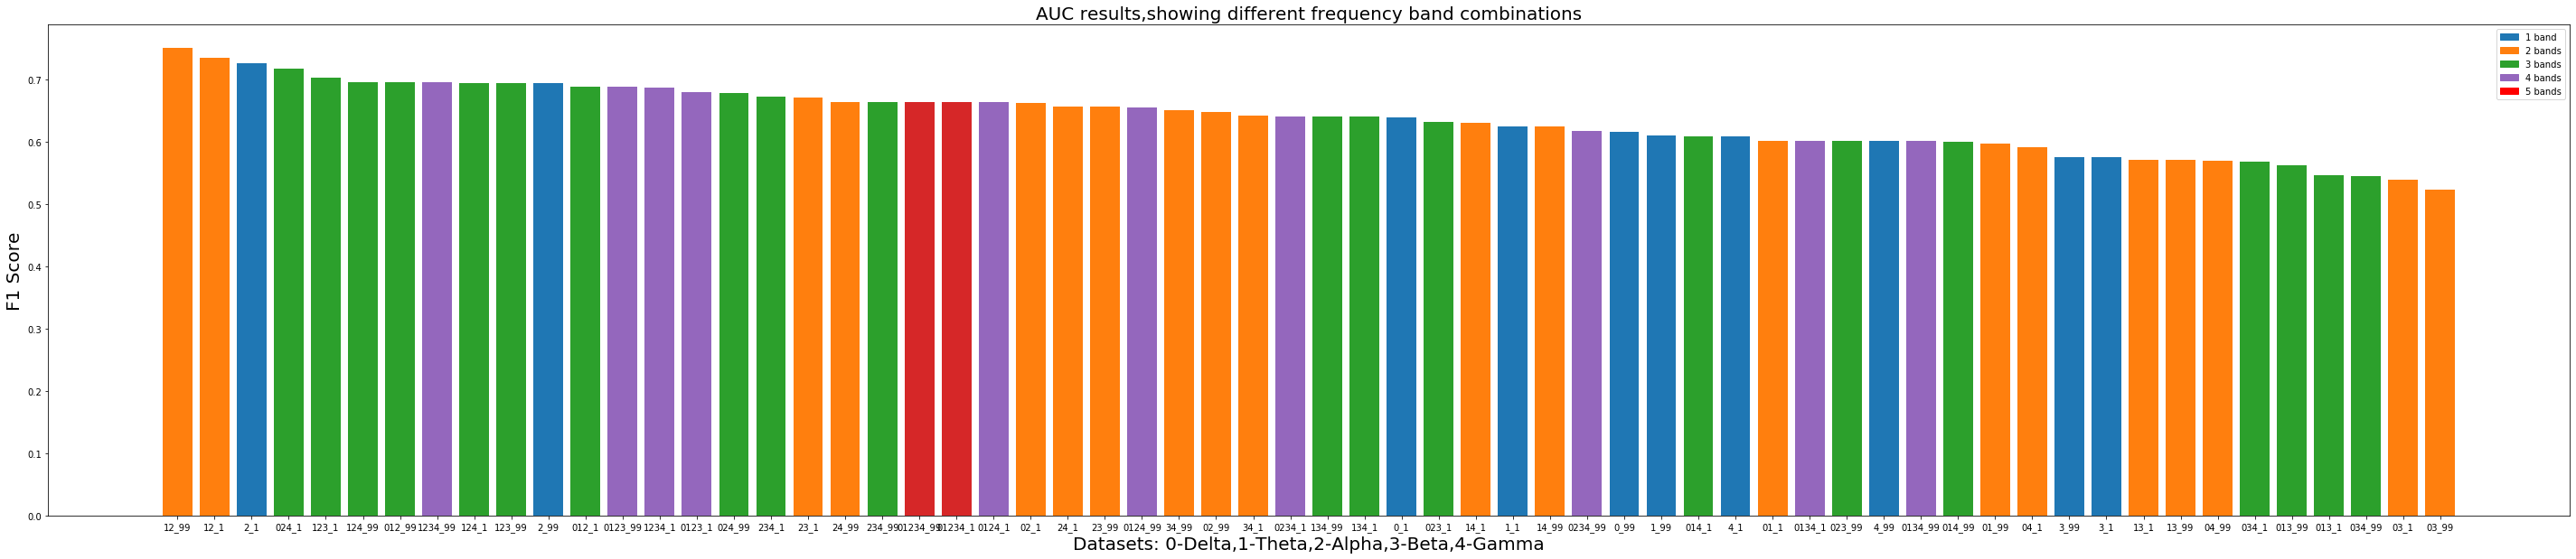

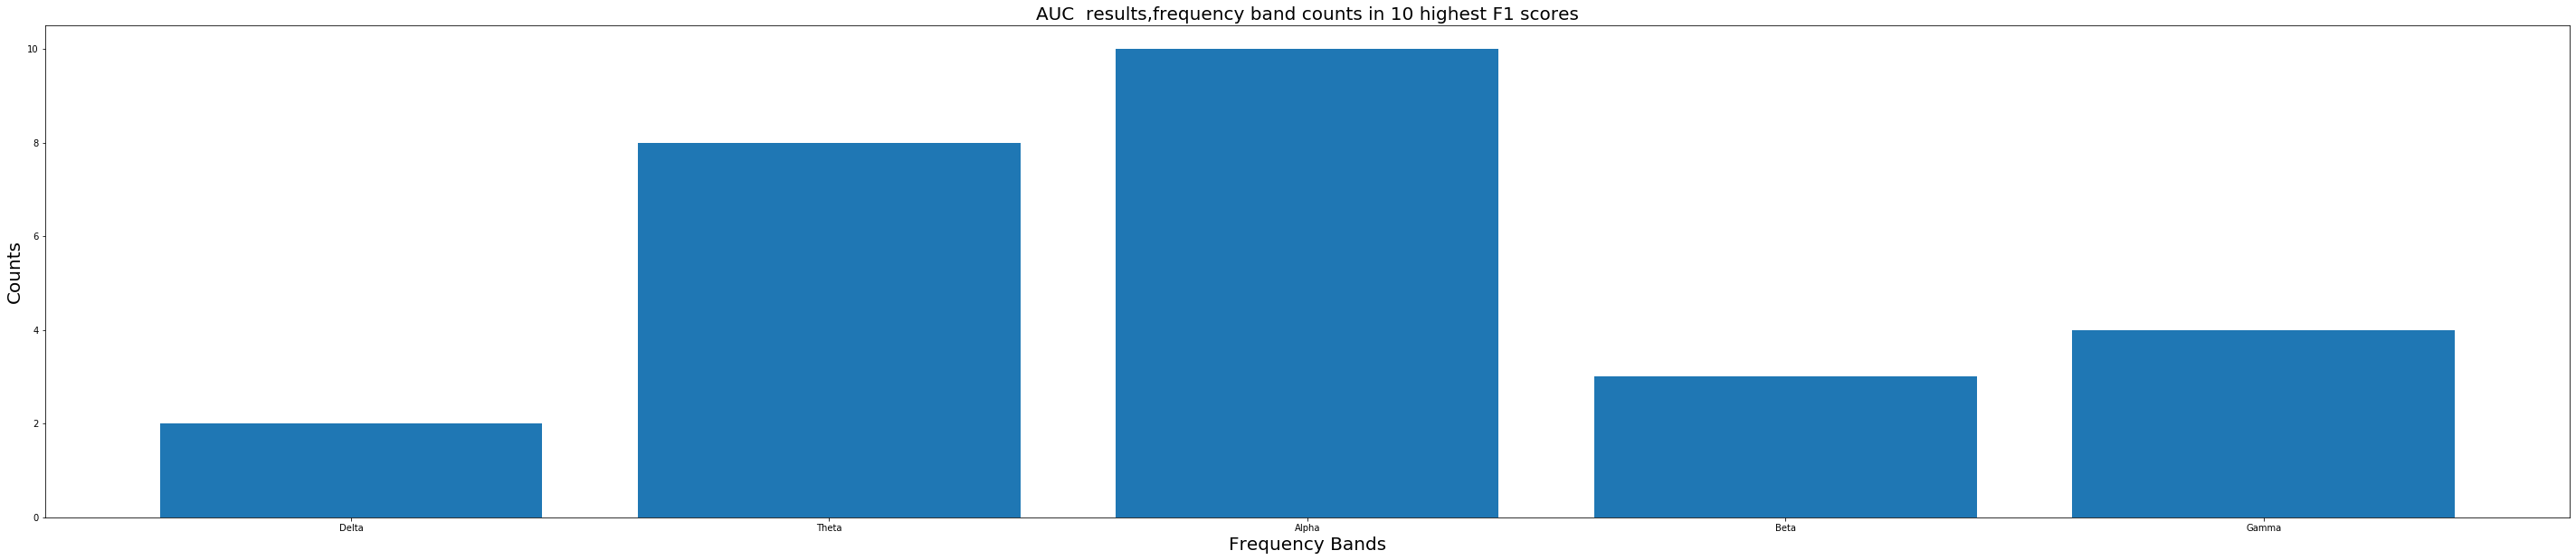

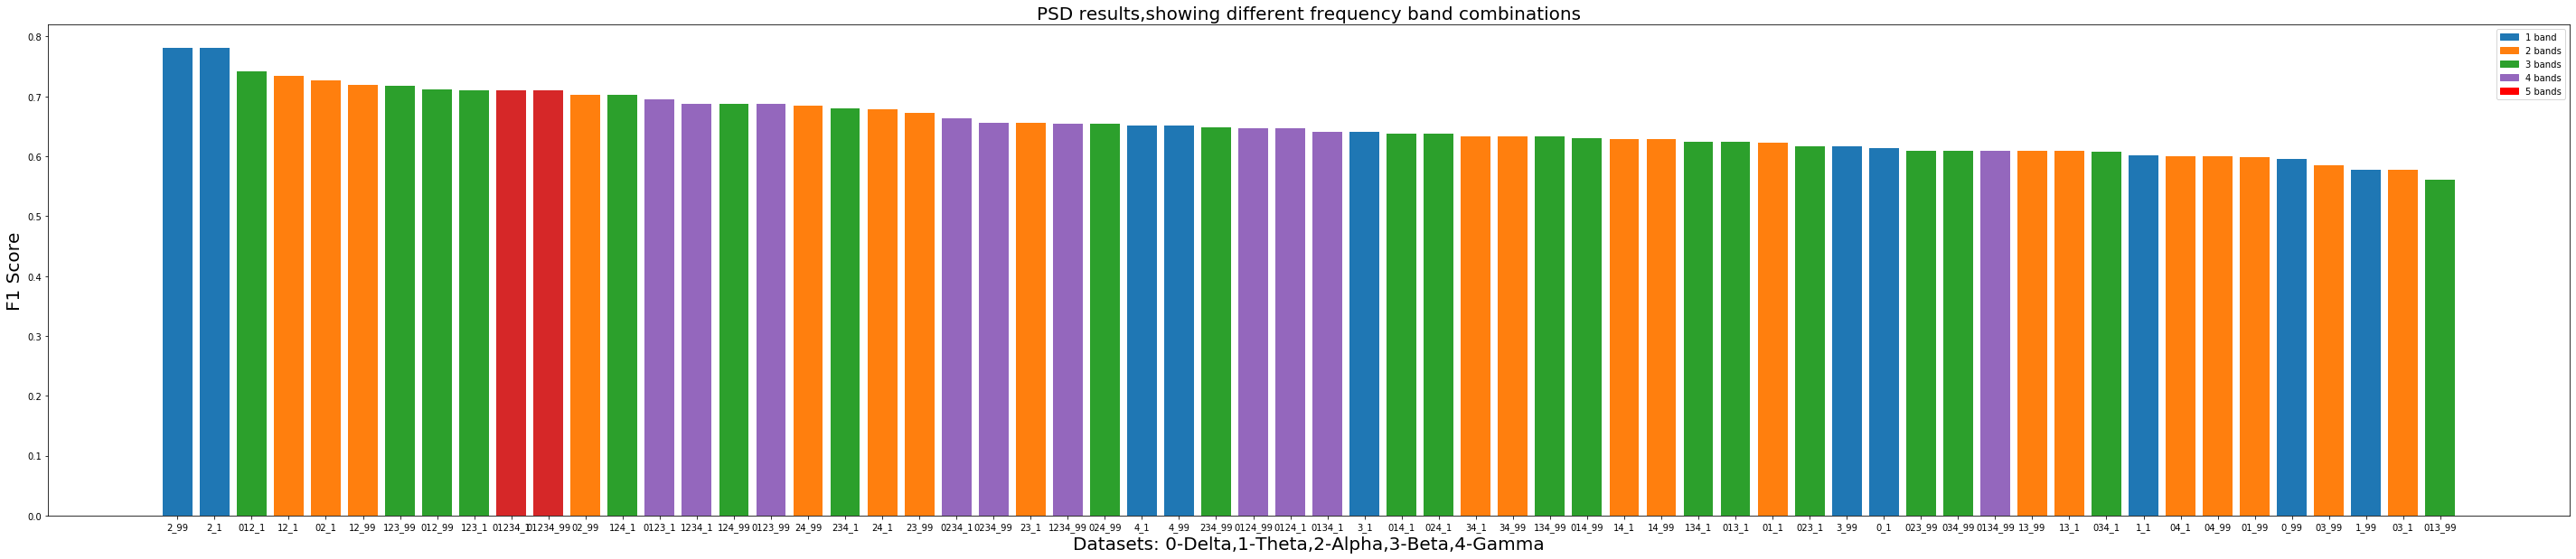

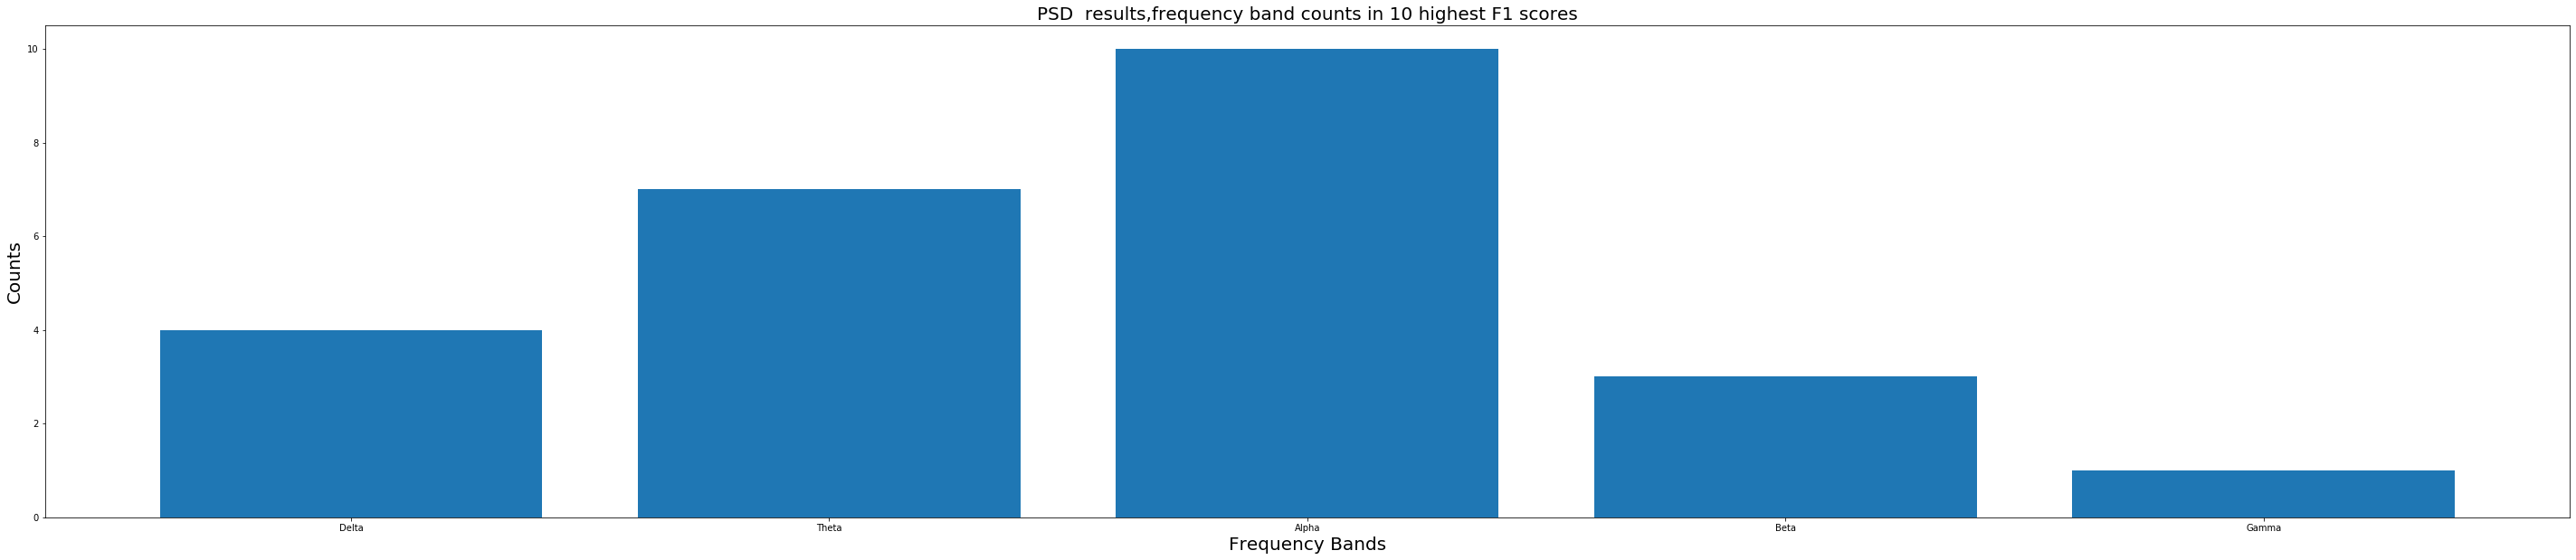

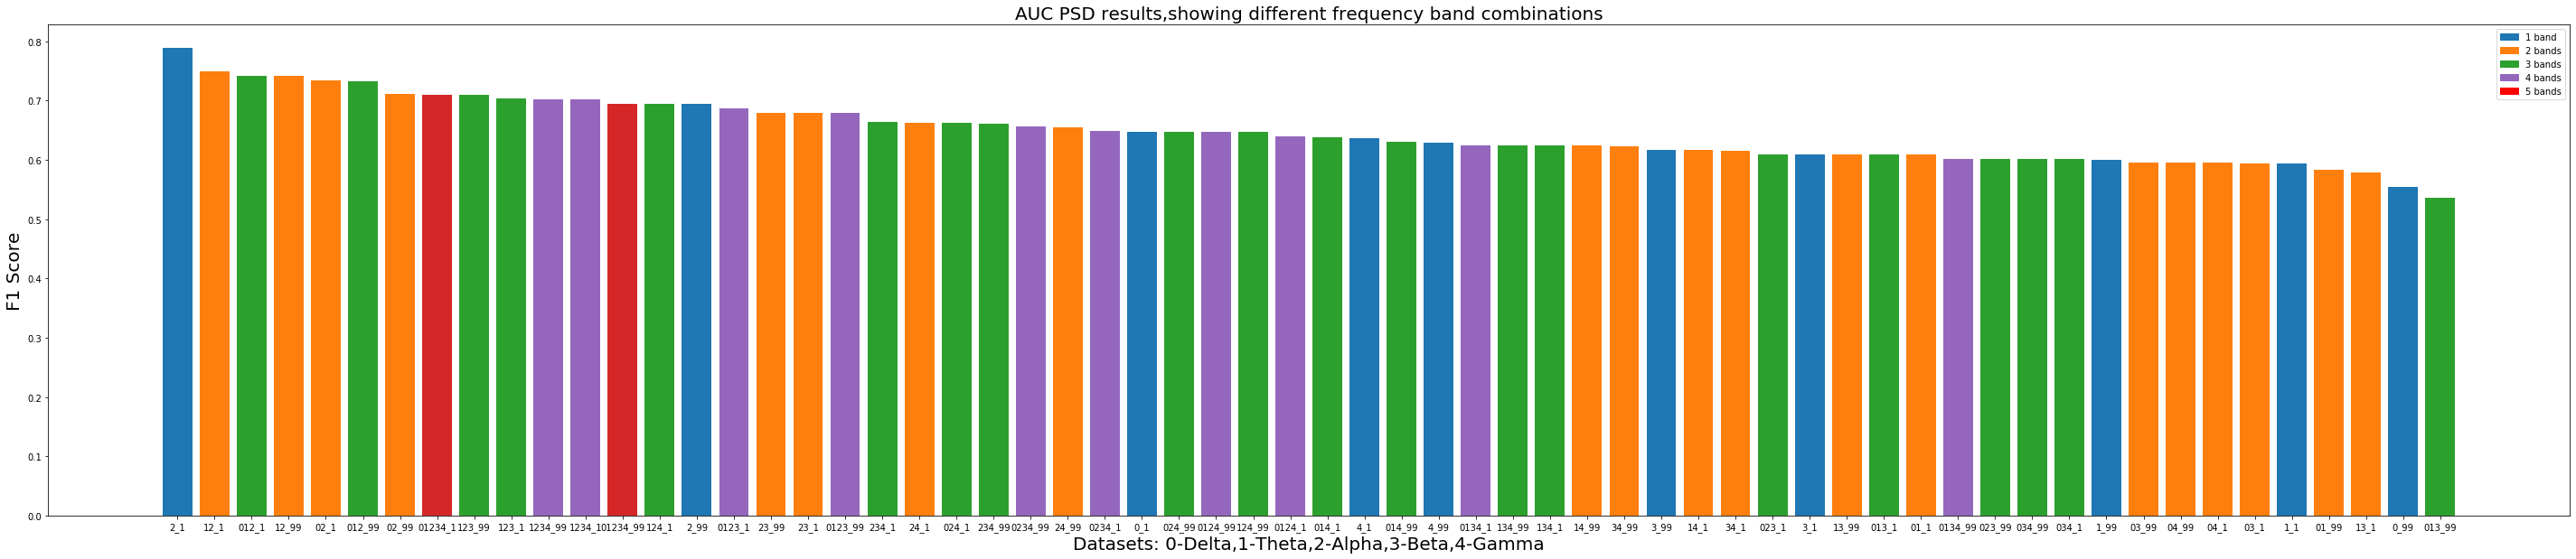

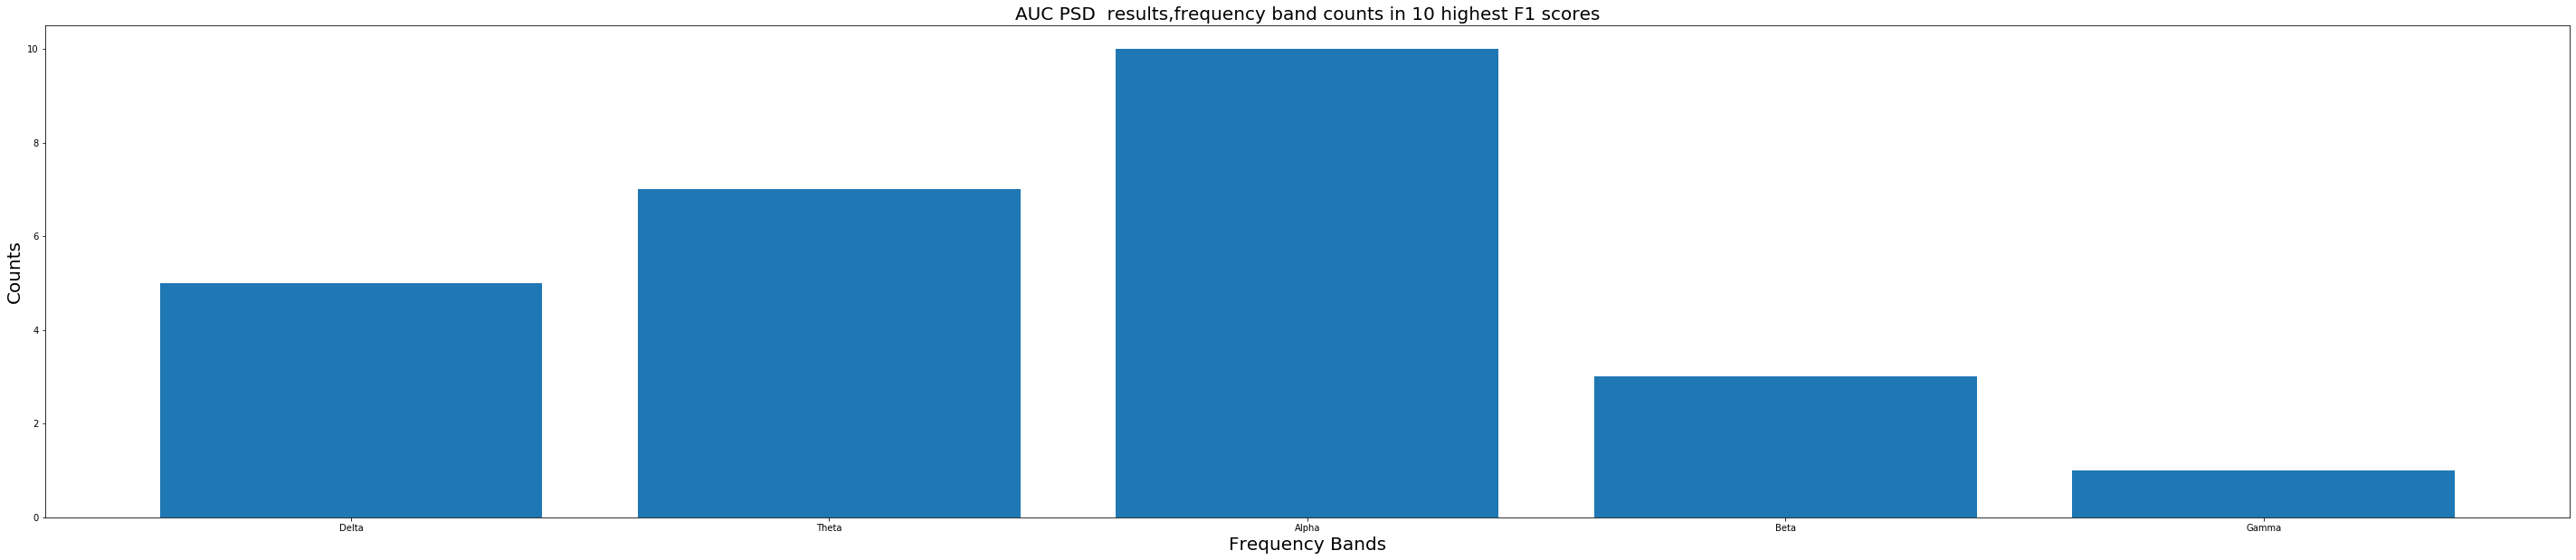

In [8]:
AUC_savedir = "F:\EEG-data\\think-count\PCA_CV_results\AUC_only\\testResults\Plots/"
PSD_savedir = "F:\EEG-data\\think-count\PCA_CV_results\PSD_only\\testResults\Plots/"
AP_savedir = "F:\EEG-data\\think-count\PCA_CV_results\AUC_PSD\\testResults\Plots/"

plot_barF1_barFreqBands(AUC_results_df,AUC_savedir)
plot_barF1_barFreqBands(PSD_results_df,PSD_savedir)
plot_barF1_barFreqBands(AP_results_df,AP_savedir)

In [12]:
#Comparing full variance retained (no PSD) vs 99% variance retained (PSD)
def plot_barVarainceCompare(results_df,savedir):
    #Sort values by F1 Score
    sorted_df = results_df.sort_values(by=['F1 Score'],ascending=False)
    splitList = sorted_df['dataset'][1].split("_")
    splitList = sorted_df['dataset'][1].split("_")
    strip = ''
    sorted_labels_1 = []
    sorted_labels_99 = []
    #Create list of sorted labels (dataset names) 
    for i in range(len(splitList)-2):
        strip+=(splitList[i]+"_")
    sorted_labels = [x.lstrip(strip) for x in sorted_df['dataset']]
    #Create list of sorted labels for 100% and 99% variance retained
    for i in range(len(sorted_labels)):
        variance = int(sorted_labels[i].split("_")[-1])
        if variance == 1:
            sorted_labels_1.append(sorted_labels[i])
        elif variance == 99:
            sorted_labels_99.append(sorted_labels[i])
    #Create figure title name 
    figtitle = ''
    for i in range(len(splitList)):
        if splitList[i]=='df':
            break 
        else:
            figtitle+=splitList[i]+" "
    #Create color labels 
    colors = [0]*len(sorted_labels)
    for i in range(len(sorted_labels)):
        variance = sorted_labels[i].split("_")[-1]
        if variance == "1":
            colors[i] = 'tab:blue'
        elif variance == "99":
            colors[i] = "tab:orange"
    #Create bar plot comparing No PSD and PSD 
    fig1,ax1 = plt.subplots(figsize=(50,10))
    ax1.bar(sorted_labels,sorted_df['F1 Score'], color=colors)
    ax1.set_title(figtitle+'results,comparing 100% (No PSD) vs 99% variance retained (PSD)',fontsize=20)
    ax1.set_xlabel('Datasets: 0-Delta,1-Theta,2-Alpha,3-Beta,4-Gamma',fontsize=20)
    ax1.set_ylabel('F1 Scores',fontsize=20)
    blue_patch = mpatches.Patch(color='tab:blue', label='No PSD')
    orange_patch = mpatches.Patch(color='tab:orange', label='PSD')
    patches = [blue_patch, orange_patch]
    ax1.legend(handles=patches)
    plt.savefig(savedir+figtitle+' F1Score_noPSDvsPSD.png')
    #Find the mean F1 Score of No PSD and PSD, print results
    dfname_list = results_df['dataset']
    names_1 = []
    names_99 = []
    f1_1 = []
    f1_99 = []
    for name in dfname_list:
        variance = name.split("_")[-1]
        if variance == '1':
            names_1.append(name)
            f1_1.append(results_df.loc[results_df['dataset']==name]['F1 Score'].values[0])
        elif variance == '99':
            names_99.append(name)
            f1_99.append(results_df.loc[results_df['dataset']==name]['F1 Score'].values[0])
    f1_1_mean = np.mean(f1_1)
    f1_99_mean = np.mean(f1_99)
    print("Mean F1 Score Comparison\nNo PSD, 100% variance retained:{:.3f}\nPSD, 99% variance retained:{:.3f}".format(f1_1_mean,f1_99_mean))

Mean F1 Score Comparison
No PSD, 100% variance retained:0.641
PSD, 99% variance retained:0.633


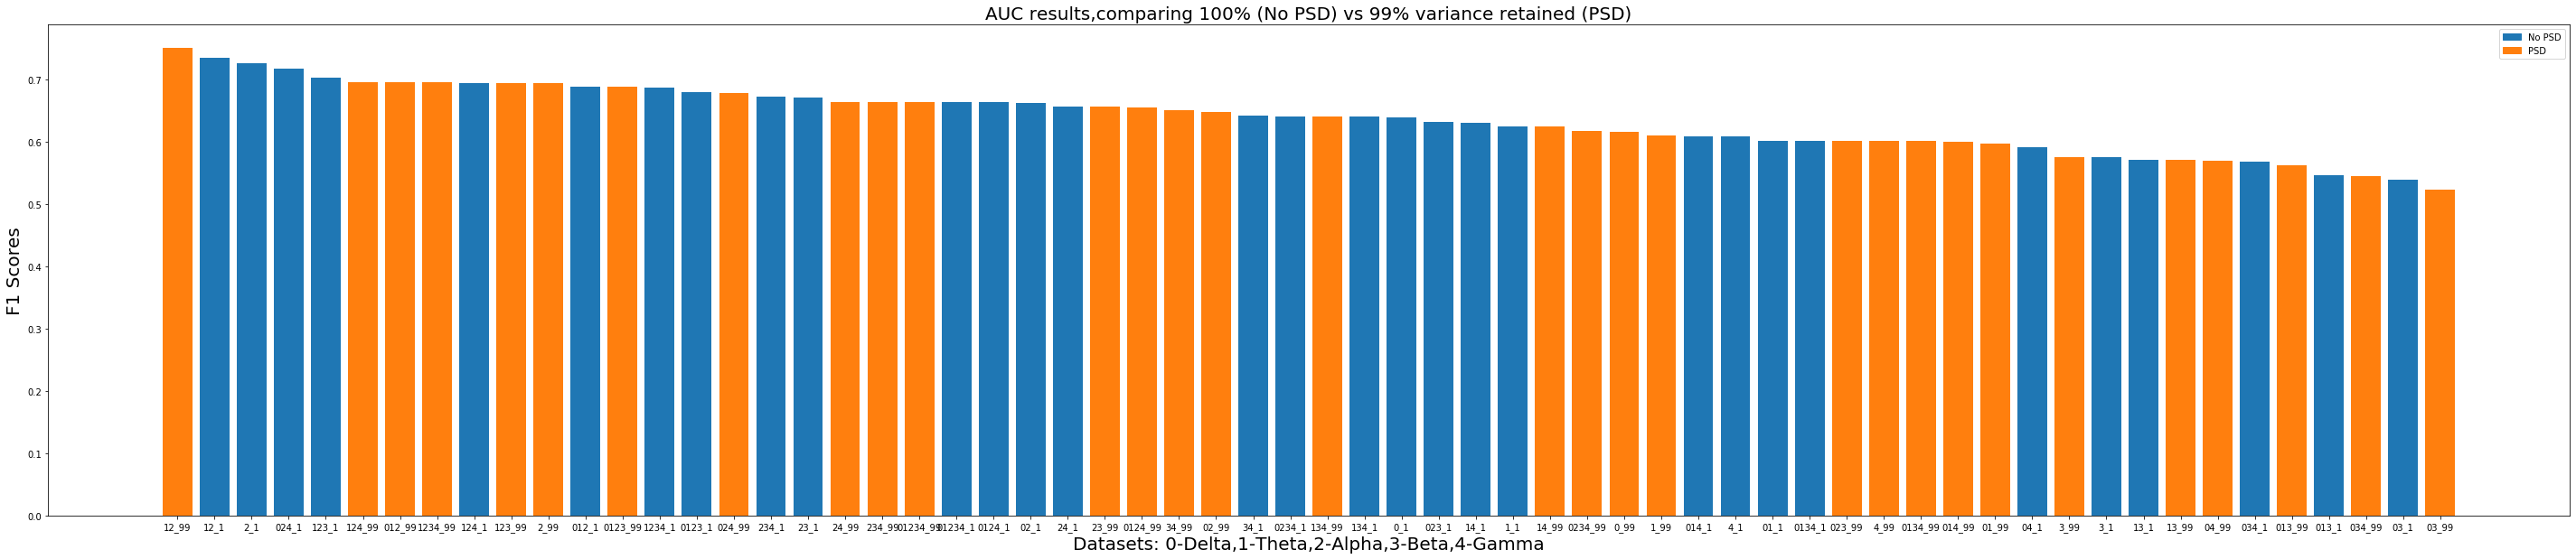

In [13]:
plot_barVarainceCompare(AUC_results_df,AUC_savedir)

Mean F1 Score Comparison
No PSD, 100% variance retained:0.658
PSD, 99% variance retained:0.648


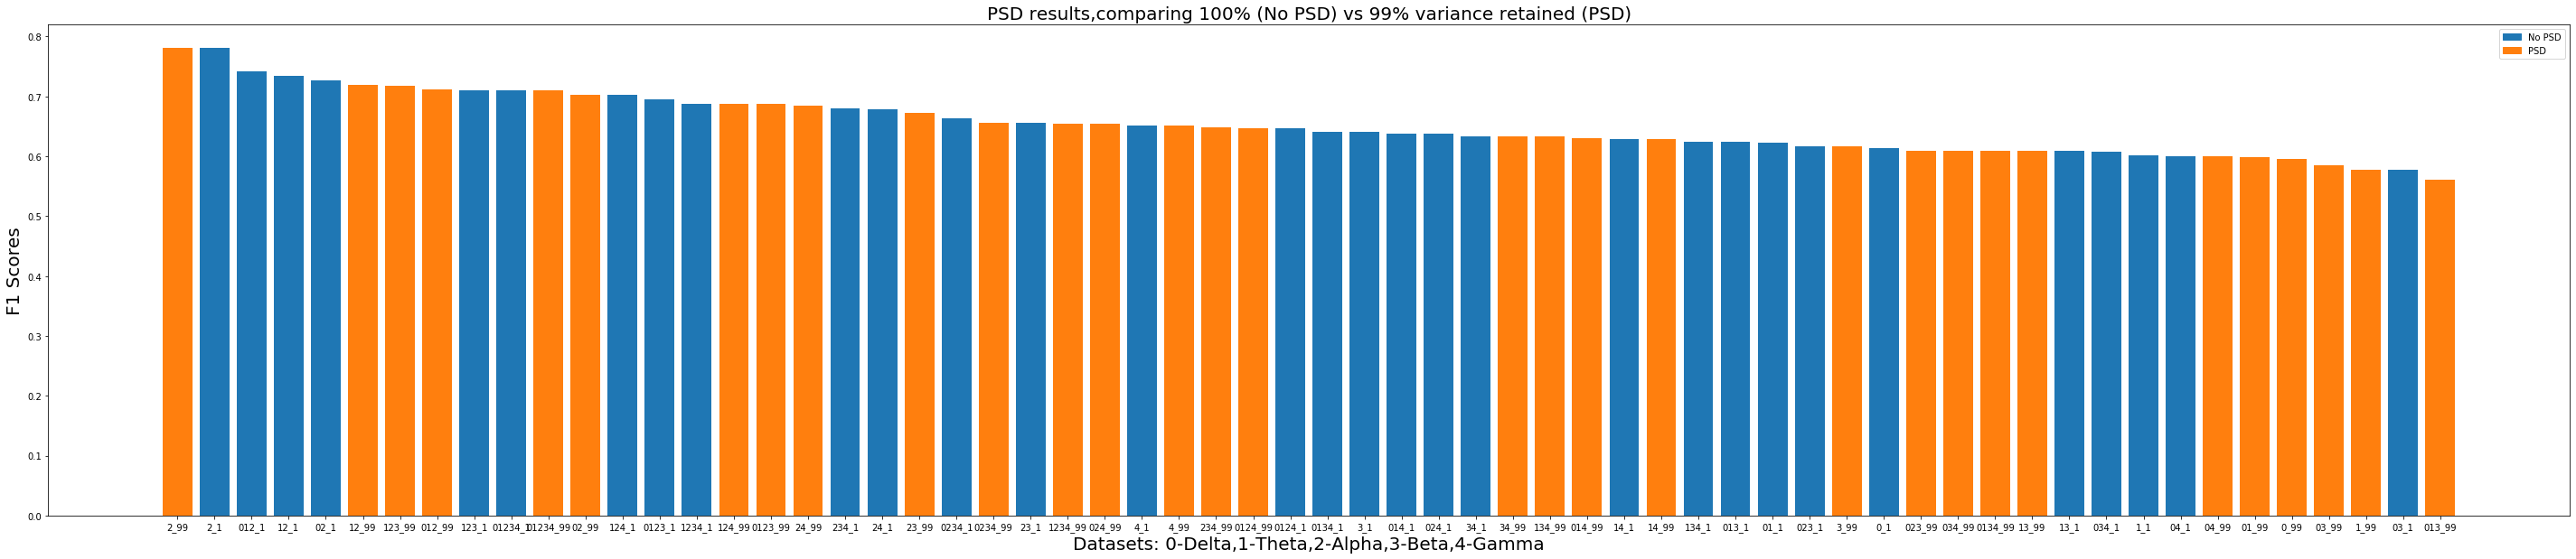

In [14]:
plot_barVarainceCompare(PSD_results_df,PSD_savedir)

Mean F1 Score Comparison
No PSD, 100% variance retained:0.654
PSD, 99% variance retained:0.642


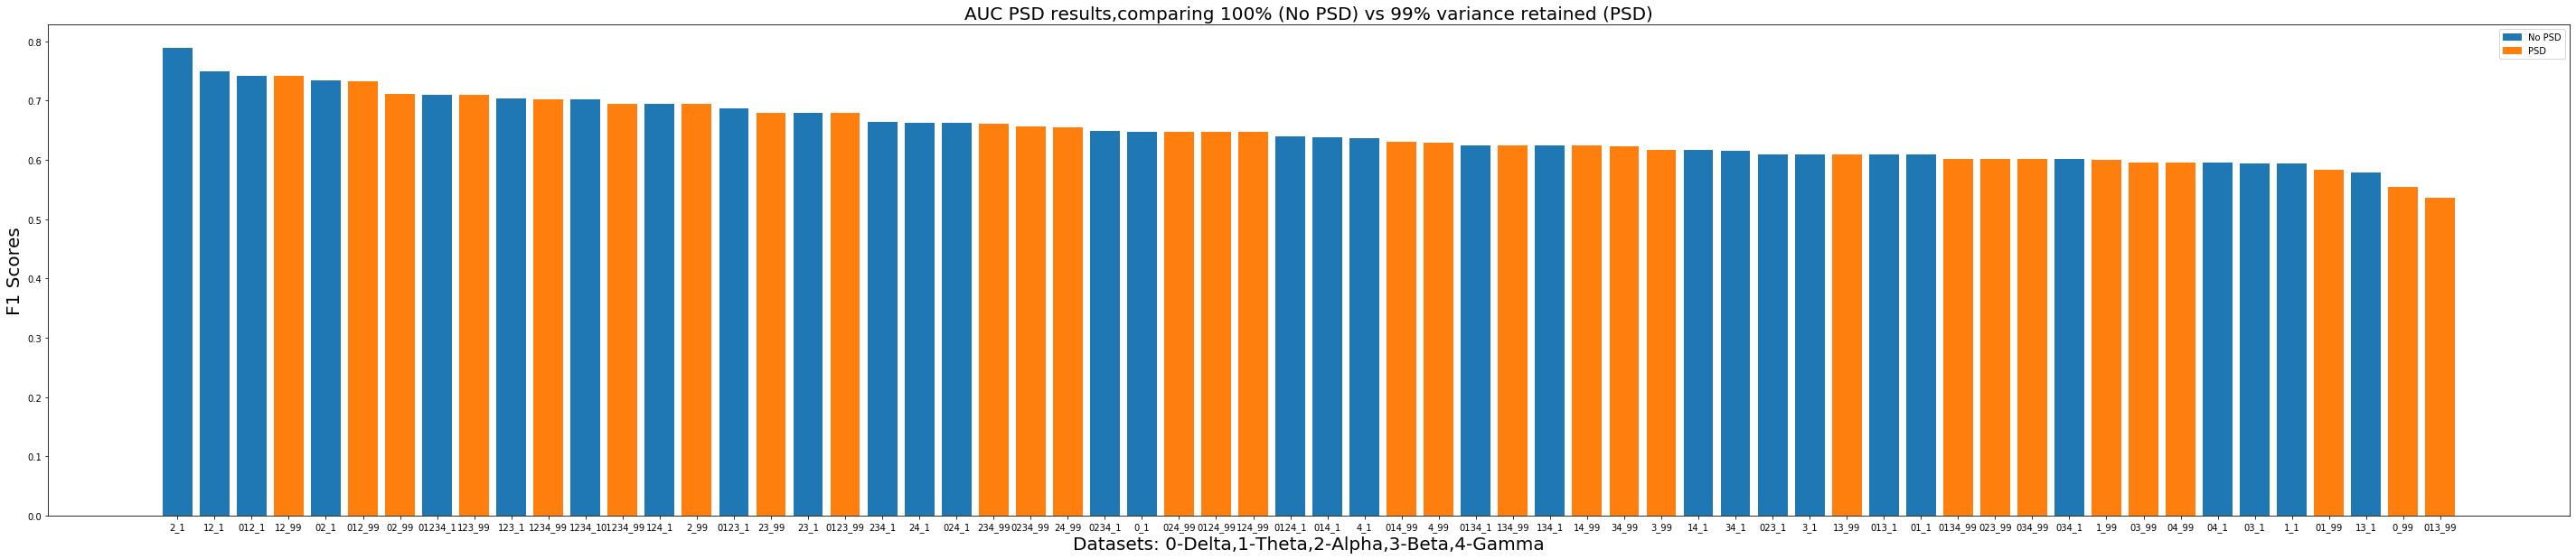

In [15]:
plot_barVarainceCompare(AP_results_df,AP_savedir)